# How to build and transpile Qiskit quantum circuits

In this guide, we show how to use the [ffsim.qiskit](../api/ffsim.qiskit.rst) module to build and transpile fermionic quantum circuits.

The following code cell imports modules and sets values that will be used in later code cells. Note that the number of qubits is twice the number of spatial orbitals.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister

import ffsim

# Let's use 4 spatial orbitals with 2 alpha electrons and 2 beta electrons.
norb = 4
nelec = (2, 2)

# Initialize qubits
qubits = QuantumRegister(2 * norb, name="q")

# Initialize random number generator
rng = np.random.default_rng(1234)

## Circuit transpilation

In this section, we show how to use transpiler passes included in ffsim to optimize quantum circuits built from fermionic gates. As a representative example circuit, we construct a circuit that prepares the Hartree-Fock state and then applies a [unitary cluster Jastrow (UCJ)](../explanations/lucj.ipynb) ansatz operator to it.

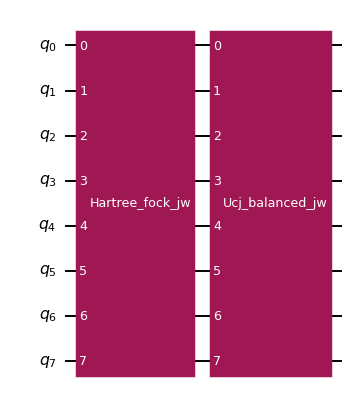

In [2]:
# Construct a random UCJ operator
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb=norb, n_reps=2, seed=rng)

# Construct circuit
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

circuit.draw("mpl", scale=0.7)

We recommend taking the following steps to transpile your quantum circuit:

- Generate a staged pass manager using the [generate_preset_pass_manager](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#generate_preset_pass_manager) function.
- Set the `pre_init` stage of your staged pass manager to `ffsim.qiskit.PRE_INIT`.
- Run the transpiler pass on your circuit.

The [ffsim.qiskit.PRE_INIT](../api/ffsim.qiskit.rst#ffsim.qiskit.PRE_INIT) constant stores a pass manager with the transpiler passes generated by the [pre_init_passes](../api/ffsim.qiskit.rst#ffsim.qiskit.pre_init_passes) function. These passes decompose gates into orbital rotations and then merges the orbital rotations, resulting in fewer [XXPlusYYGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.XXPlusYYGate#xxplusyygate) in the final transpiled circuit. See [Qubit gate decompositions of fermionic gates](../explanations/qiskit-gate-decompositions.ipynb#Unitary-cluster-Jastrow-(UCJ)-operator) for a more detailed explanation of how this works.

In [3]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Initialize quantum device backend
backend = GenericBackendV2(2 * norb, basis_gates=["cp", "xx_plus_yy", "p", "x"])

# Create a pass manager for circuit transpilation
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Set the pre-initialization stage of the pass manager with passes suggested by ffsim
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

# Transpile the circuit
transpiled = pass_manager.run(circuit)

transpiled.count_ops()

OrderedDict([('cp', 56), ('xx_plus_yy', 32), ('p', 24), ('x', 4)])

## Overview of gates

In this section, we give an overview of the quantum gates available in ffsim and provide usage examples.

### State preparation gates

The state preparation gates are meant to be applied to the zero state. Their behavior when applied to other states is not guaranteed.

#### Prepare Hartree-Fock state

In [4]:
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)

#### Prepare Slater determinant

In [5]:
occupied_orbitals = ([0, 2], [0, 1])
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.PrepareSlaterDeterminantJW(
        norb, occupied_orbitals, orbital_rotation=orbital_rotation
    ),
    qubits,
)

### Unitary transformation gates

These gates can be applied to any state.

#### Orbital rotation

In [6]:
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.OrbitalRotationJW(norb, orbital_rotation), qubits)

#### Number operator sum evolution

In [7]:
coeffs = rng.standard_normal(norb)
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.NumOpSumEvolutionJW(norb, coeffs, time=1.0), qubits)

#### Diagonal Coulomb evolution

In [8]:
diag_coulomb_mat = ffsim.random.random_real_symmetric_matrix(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(norb, diag_coulomb_mat, time=1.0), qubits
)

#### Spin-balanced unitary cluster Jastrow (UCJ) operator

In [9]:
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb=norb, n_reps=2)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

#### Spin-unbalanced unitary cluster Jastrow (UCJ) operator

In [10]:
ucj_op = ffsim.random.random_ucj_op_spin_unbalanced(norb=norb, n_reps=2)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.UCJOpSpinUnbalancedJW(ucj_op), qubits)

#### Trotter simulation of double-factorized Hamiltonian

In [11]:
df_hamiltonian = ffsim.random.random_double_factorized_hamiltonian(norb, seed=rng)
circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.SimulateTrotterDoubleFactorizedJW(
        df_hamiltonian, time=1.0, n_steps=1, order=0
    ),
    qubits,
)